# Indirect Object Identification Circuit in Pythia

## Imports

In [14]:
import os

import torch
from torch import Tensor
import numpy as np
import einops
import json
from fancy_einsum import einsum
# import circuitsvis as cv

from transformers import AutoModelForCausalLM, AutoTokenizer

import transformer_lens.utils as tl_utils
from transformer_lens import HookedTransformer
import transformer_lens.patching as patching

from jaxtyping import Float
import plotly.express as px
import plotly.io as pio

from functools import partial

from torchtyping import TensorType as TT

from path_patching_cm.path_patching import Node, IterNode, path_patch, act_patch
from path_patching_cm.ioi_dataset import IOIDataset, NAMES
from neel_plotly import imshow as imshow_n

from utils.metrics import compute_logit_diff



if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [15]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(tl_utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=tl_utils.to_numpy(tensor), **kwargs).show(renderer)

def two_lines(tensor1, tensor2, renderer=None, **kwargs):
    px.line(y=[tl_utils.to_numpy(tensor1), tl_utils.to_numpy(tensor2)], **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = tl_utils.to_numpy(x)
    y = tl_utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [16]:
# =============================================================================
import kaleido
pio.renderers.default = 'png' # USE IF MAKING GRAPHS FOR NOTEBOOK EXPORT
# =============================================================================

## Parameters

In [17]:
BASE_MODEL = "pythia-160m"
VARIANT = None
CACHE = "model_cache"
CHECKPOINT = 143000
torch.set_grad_enabled(False)

IOI_DATASET_SIZE = 70

## Model Setup

In [18]:
def get_model(base_model="pythia-160m", variant=None, checkpoint=143000, cache="model_cache"):
    if not variant:
        model = HookedTransformer.from_pretrained(
            base_model,
            checkpoint_value=checkpoint,
            center_unembed=True,
            center_writing_weights=True,
            fold_ln=True,
            refactor_factored_attn_matrices=False,
            dtype=torch.bfloat16,
            **{"cache_dir": cache},
        )
    else:
        revision = f"step{checkpoint}"
        source_model = AutoModelForCausalLM.from_pretrained(
        VARIANT, revision=revision, cache_dir=cache
        ).to(device).to(torch.bfloat16)

        model = HookedTransformer.from_pretrained(
            base_model,
            hf_model=source_model,
            center_unembed=False,
            center_writing_weights=False,
            fold_ln=False,
            dtype=torch.bfloat16,
            **{"cache_dir": cache},
        )
        
    model.cfg.use_split_qkv_input = True
    model.cfg.use_attn_result = True
    model.cfg.use_hook_mlp_in = True

    return model

## Data Setup

In [19]:
# model = get_model()
# ds = UniversalPatchingDataset.from_ioi(model, IOI_DATASET_SIZE)
# # logit_diff_metric = partial(compute_logit_diff,mode='simple')

In [20]:
# clean_logits, clean_cache = model.run_with_cache(ds.toks)
# # corrupted_logits, corrupted_cache = model.run_with_cache(ds.flipped_toks)

# # clean_logit_diff = logit_diff_metric(clean_logits, ds.answer_toks, ds.positions)
# # print(f"Clean logit diff: {clean_logit_diff:.4f}")

# # corrupted_logit_diff = logit_diff_metric(corrupted_logits, ds.answer_toks, ds.positions)
# # print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")

## Attention Head Comparison

In [21]:
def get_components(cache, positions, layer_idx, head_idx):
    return {
        "act_Q": cache[f"blocks.{layer_idx}.attn.hook_q"][:, positions, head_idx, :].detach().to("cpu"),
        "act_K": cache[f"blocks.{layer_idx}.attn.hook_k"][:, positions, head_idx, :].detach().to("cpu"),
        "act_V": cache[f"blocks.{layer_idx}.attn.hook_v"][:, positions, head_idx, :].detach().to("cpu"),
        "act_Z": cache[f"blocks.{layer_idx}.attn.hook_z"][:, positions, head_idx, :].detach().to("cpu"),
        "attn_pattern": cache[f"blocks.{layer_idx}.attn.hook_pattern"][:, head_idx, positions, :].detach().to("cpu"),
    }

In [22]:
# def component_cosine_sim(model_a, model_b, heads, dataset=ds):
#     _, cache_a = model_a.run_with_cache(dataset.toks)
#     _, cache_b = model_b.run_with_cache(dataset.toks)

#     cosine_sims = dict()

#     for layer_idx, head_idx in heads:

#         cosine_sims[f"L{layer_idx}H{head_idx}"] = dict()

#         components_a = get_components(cache_a, dataset.positions, layer_idx, head_idx)
#         components_b = get_components(cache_b, dataset.positions, layer_idx, head_idx)

#         for k in components_a.keys():
#             cosine_sims[f"L{layer_idx}H{head_idx}"][k] = torch.nn.functional.cosine_similarity(components_a[k].flatten(), components_b[k].flatten(), dim=0).item()

#     return cosine_sims

In [23]:
# model_a = get_model(checkpoint=10000)
# model_b = get_model(checkpoint=5000)

# cosine_sims = component_cosine_sim(model_a, model_b, [(8, 9)])
# cosine_sims

### Get Top Heads

In [24]:
# import json

# # suppress warnings
# import warnings
# warnings.filterwarnings("ignore")

# model_a = get_model(checkpoint=143000)

# similarity_through_time = dict()

# heads = [(8, 9), (10, 1), (4, 11), (6, 6), (7, 2), (2, 6), (6, 5), (4, 6), (10, 7), (8, 2), (8, 10), (7, 9), (4, 1), (4, 8), (5, 8), (9, 8),
#          (10, 11), (9, 6), (6, 11), (5, 0), (3, 0), (11, 6)]

# for c in range(1000, 142000, 1000):
    
#     model_b = get_model(checkpoint=c)

#     cosine_sims = component_cosine_sim(model_a, model_b, heads)
#     similarity_through_time[c] = cosine_sims

#     print(f"Checkpoint: {c} - Head Component Cosine Similarity to 143K: {cosine_sims}")

#     # save json
#     with open("similarity_through_time_last_pos.json", "w") as f:
#         json.dump(similarity_through_time, f)


In [25]:
# load json
import pandas as pd
with open("similarity_through_time_last_pos.json", "r") as f:
    similarity_through_time = json.load(f)

def plot_head_component_cosine_similarity(head, similarity_through_time, renderer=None):
    # Convert nested dictionary to a list of dictionaries
    data_list = []
    for checkpoint, heads in similarity_through_time.items():
        for item, value in heads[head].items():
            data_list.append({'Checkpoint': checkpoint, 'Item': item, 'Value': value})

    # Convert list to Pandas DataFrame
    df = pd.DataFrame(data_list)

    # Use Plotly Express to create the line chart
    # Ensure each 'Item' gets its own line by specifying it in the 'color' parameter
    fig = px.line(df, x='Checkpoint', y='Value', color='Item',
                  title=f'Attention Head {head} Component Cosine Similarity To Final Checkpoint')

    # Show the figure
    fig.show(renderer=renderer)

    return df

#df = plot_head_component_cosine_similarity("L8H9", similarity_through_time)

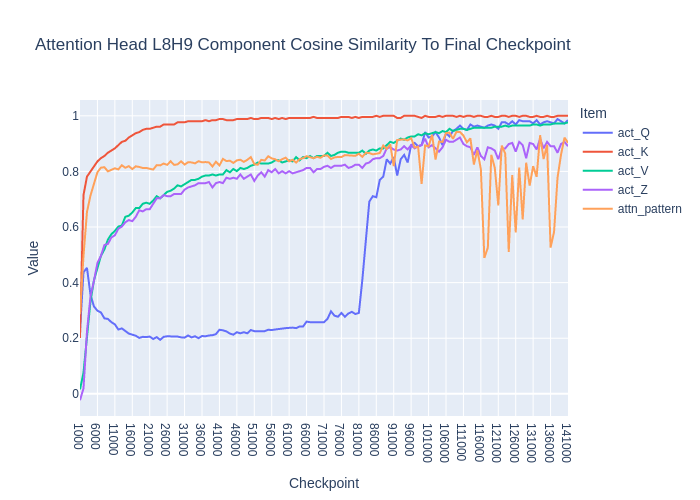

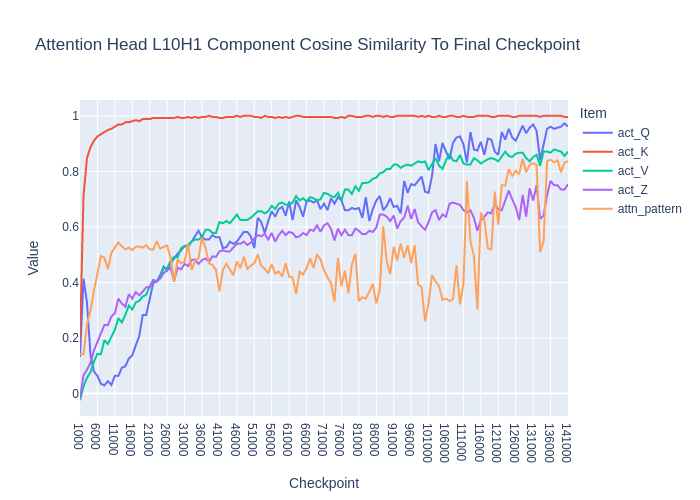

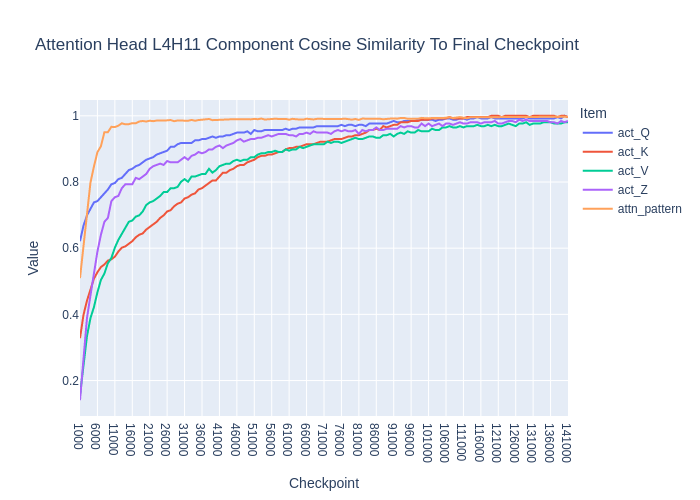

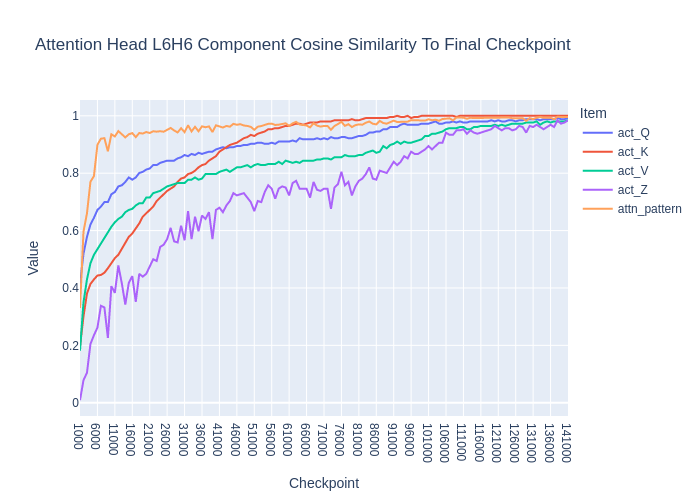

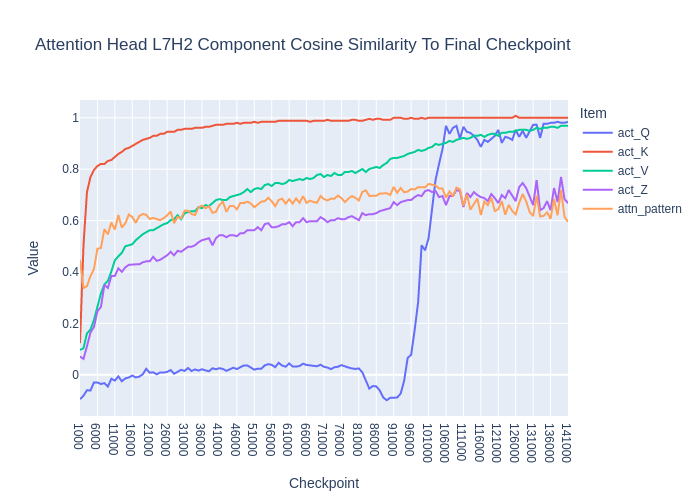

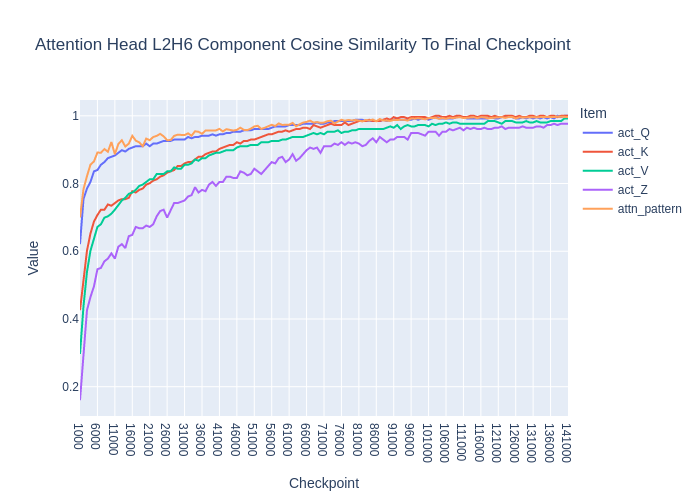

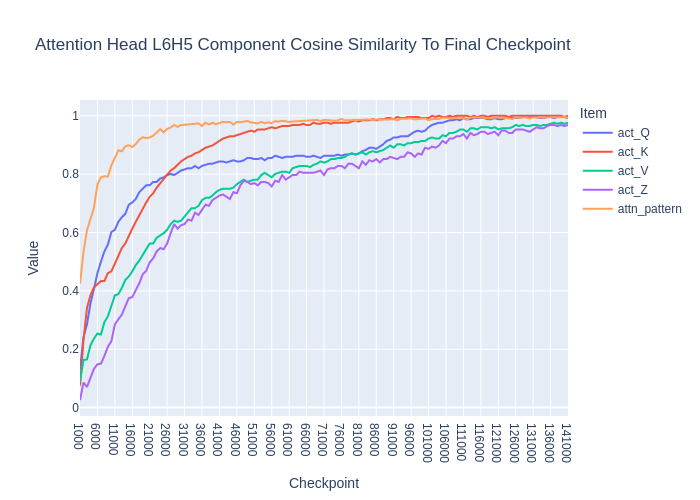

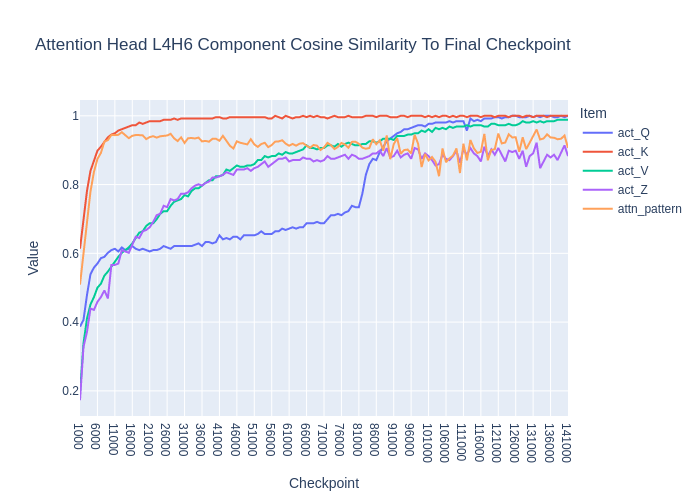

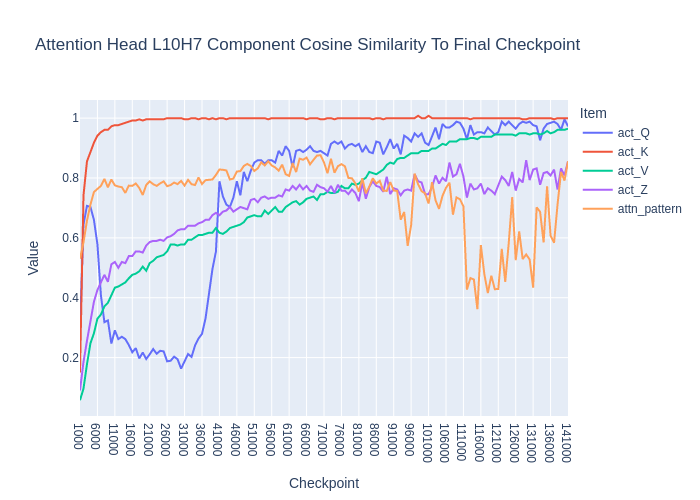

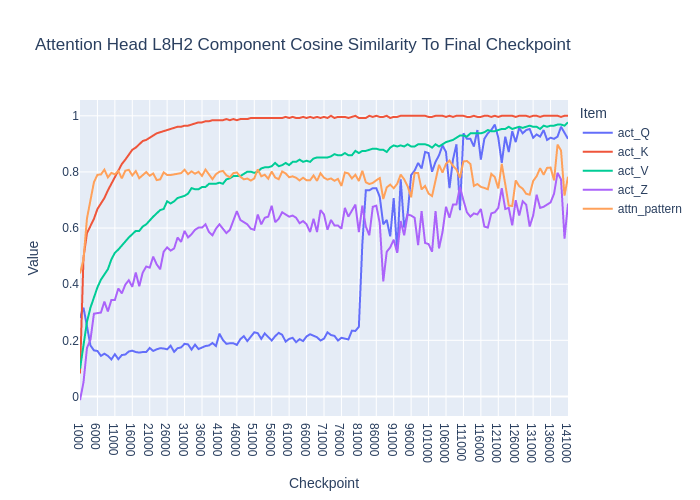

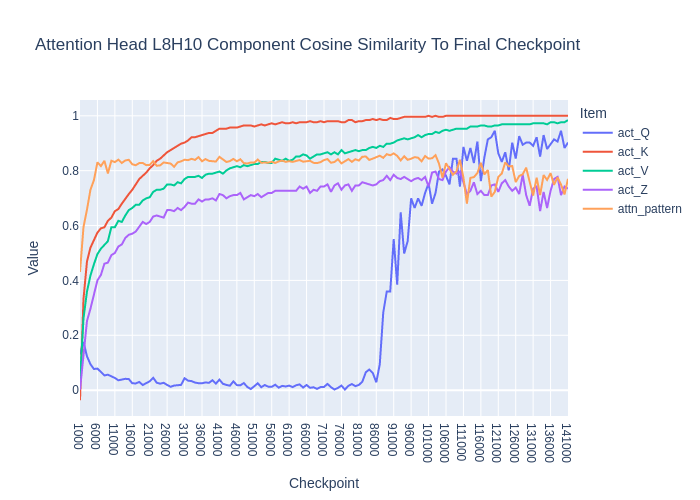

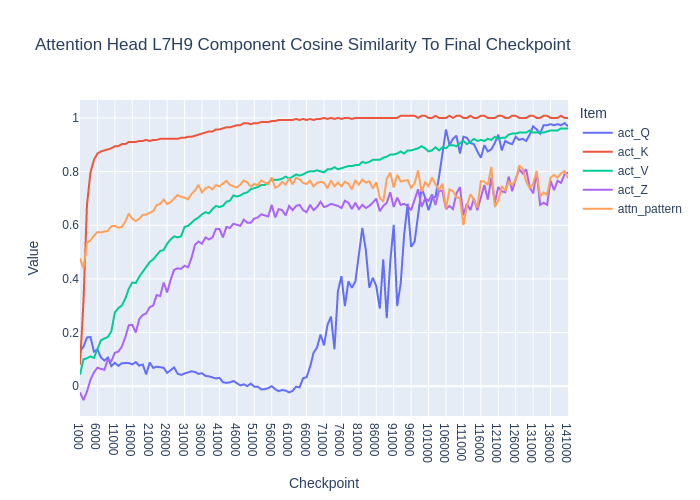

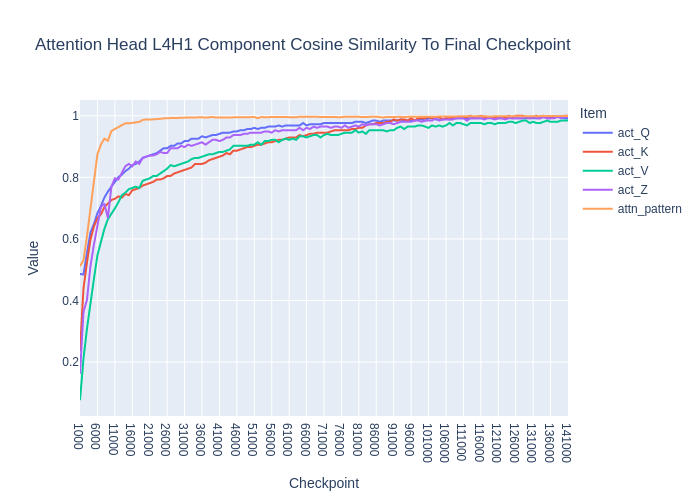

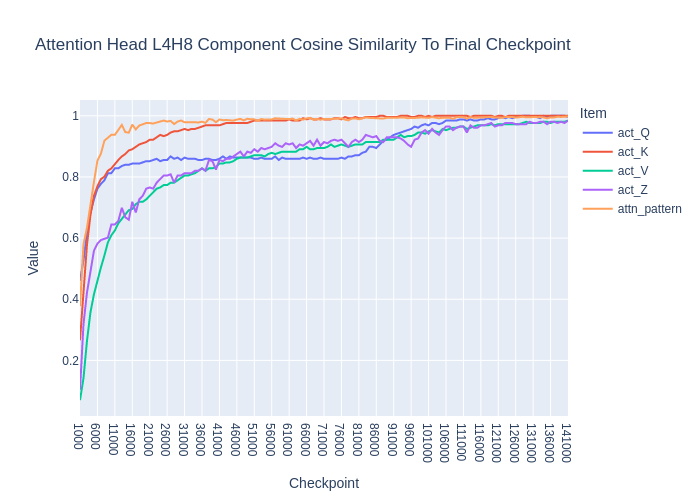

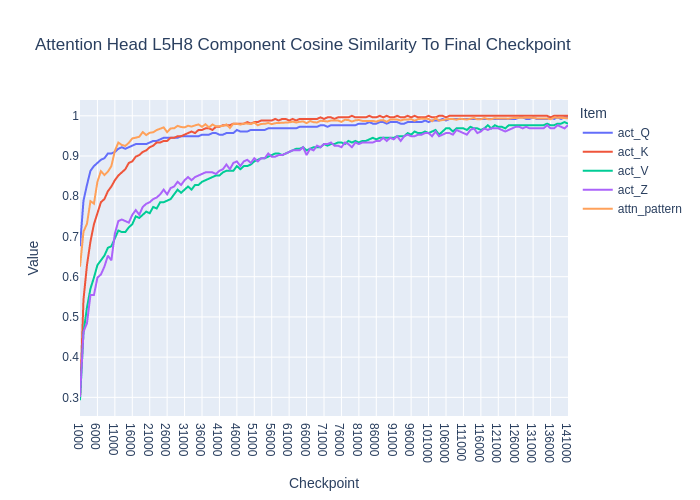

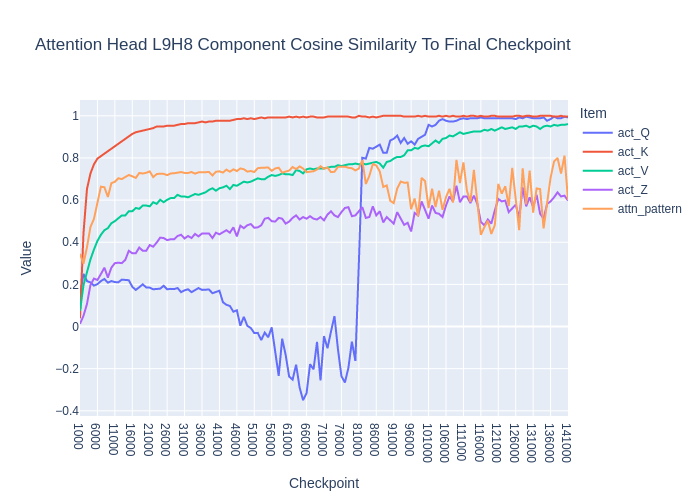

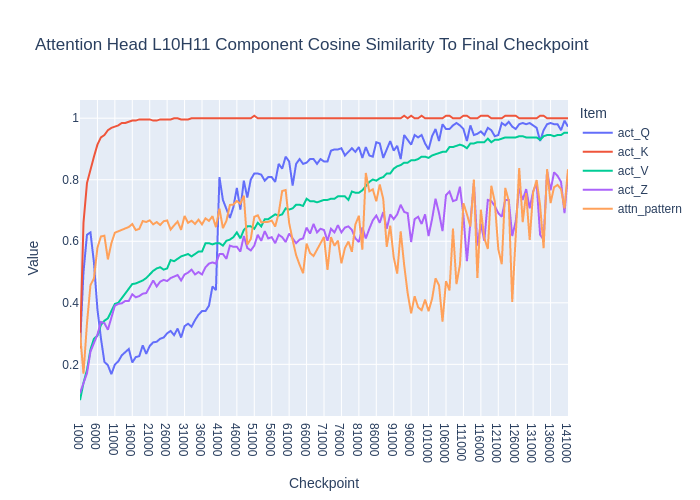

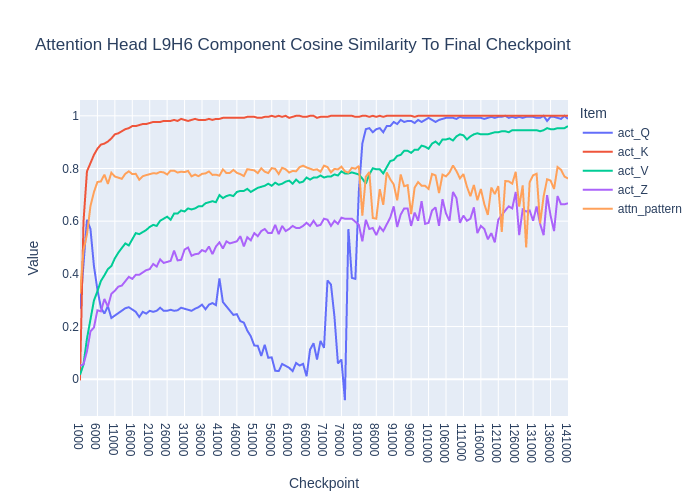

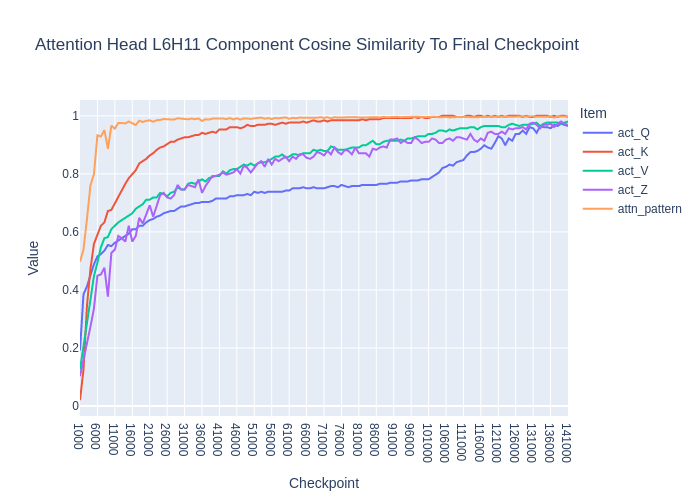

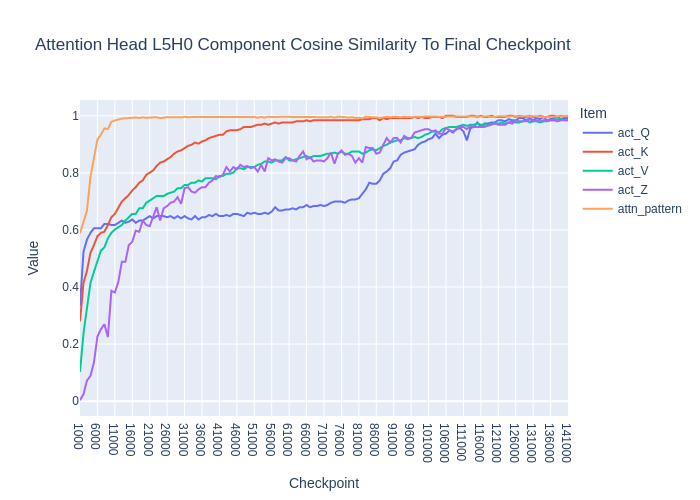

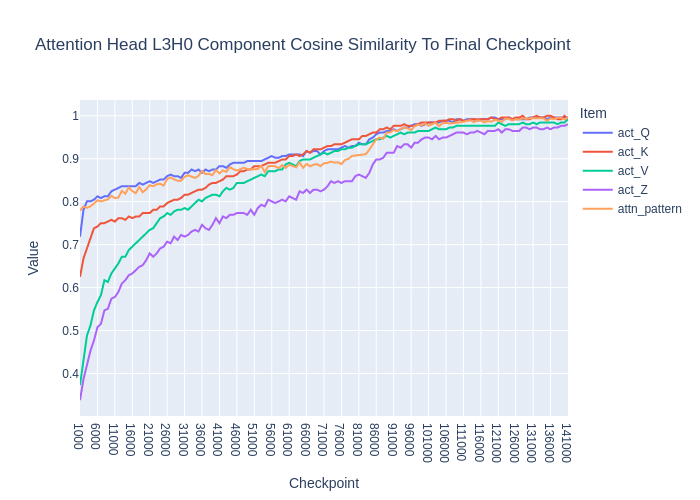

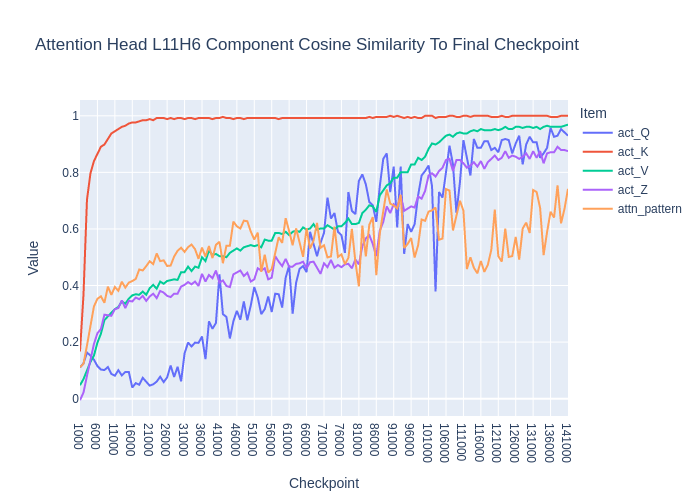

In [26]:
# plot all heads
for head in similarity_through_time['1000'].keys():
    plot_head_component_cosine_similarity(head, similarity_through_time)